In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

sns.set_theme()

In [2]:
posteriors = pd.read_csv('./data/poisson_posteriors_liver_data.csv',index_col=0)
data_points = pd.read_csv('./data/poisson_filtered_data_liver.csv',index_col=0)
label = pd.read_csv('./data/poisson_labels_liver_data.csv',index_col=0)
label_data = pd.read_csv('./data/poisson_labels_liver_data.csv',index_col=0)

# Making a function for lambda plotting

In [3]:
def change_width(ax, new_value) :
    cnt = 0
    for patch in ax.patches :
        current_width = patch.get_width()
        patch.set_width(new_value[cnt] * len(new_value))
        patch.set_x((np.cumsum(new_value)[cnt]-new_value[cnt])*len(new_value))
        cnt = (cnt+1) % len(new_value)
            
def lambda_plotting(data_points, posteriors = None, labels = None,ax = None):    
    if posteriors is None and labels is None :
        raise Exception('posteriors and labels can\'t be both None!') 
    if ax is None :
        raise Exception('ax can not be null')
    if labels is None :
        labels = pd.DataFrame(pd.Series(np.argmax(posteriors.values, axis=1)))
    
    
    data_points_percentage = data_points.copy()
    data_points_percentage['label'] = labels.values
    data_percentages = data_points_percentage.groupby('label').sum()

    for col in data_percentages:
        data_percentages[col] = data_percentages[col] / np.sum(data_percentages[col])
    sum_hor = np.sum(data_percentages, axis = 1)
    for col in data_percentages:
        data_percentages[col] = data_percentages[col] / sum_hor
    
    data_percentages.iloc[:,:] = np.cumsum(data_percentages.values, axis = 1)
    
    
    val,ori,label = [],[],[]
    for col in data_percentages:
        val.extend(data_percentages[col].values)
        ori.extend([col]*len(data_percentages))
        label.extend(list(range(1,len(data_percentages)+1)))
    df = pd.DataFrame({'value':val,'origin':ori, 'label': label})
    
    
    
    
    sns.barplot(data = df, 
                y = 'value', 
                x = 'label', 
                hue = 'origin', 
                dodge = False, 
                hue_order = data_percentages.columns[::-1], 
                palette = 'viridis',
                ax = ax
               );
    
    widths = labels.value_counts(normalize = True).sort_index().values
    change_width(ax = ax, new_value = widths)
    
    ax.set_xticks((np.cumsum(widths)-widths)*len(widths))
    ax.set_xticklabels(list(range(1,len(widths)+1)))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #plt.tight_layout()

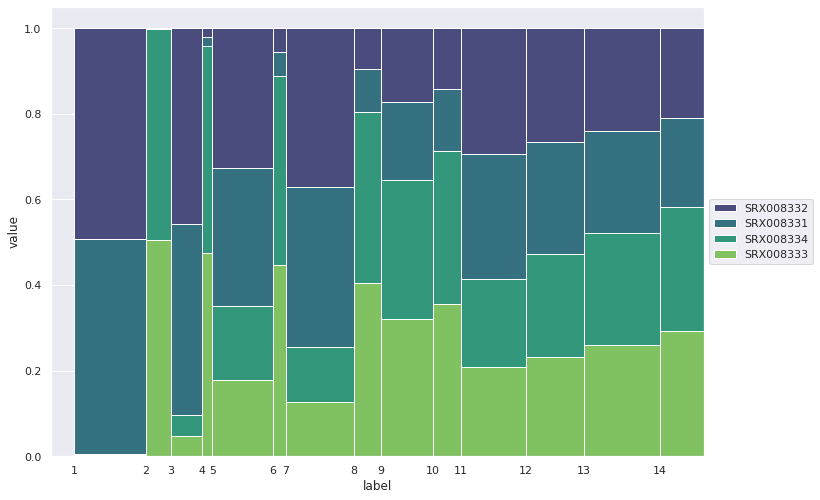

In [4]:
fig, ax = plt.subplots()
lambda_plotting(data_points, posteriors=posteriors, ax = ax);
fig.set_size_inches(11.7, 8.27)

# Plotting the results

In [29]:
data_points = pd.read_csv('./results/sim_data_1.csv', index_col=0)
labels = pd.read_csv('./results/fly_data_labels.csv', index_col=0)
poisson_posteriors = pd.read_csv('./results/sim_data_poisson_clustering_29.csv', index_col=0)
npMSL_posteriors = pd.read_csv('./results/npMSL_sim_data_posteriors.csv', index_col=0)
mask = np.max(data_points.values, axis = 1) > 0 
#poisson_posteriors = pd.read_csv('./results/sim_data_poisson_cluster_posteriors.csv', index_col=0)
#npEM_posteriors = pd.read_csv('./results/sim_data_npEM_cluster_posteriors.csv', index_col=0)
#npMSL_posteriors = pd.read_csv('./results/sim_data_npMSL_cluster_posteriors.csv', index_col=0)

In [33]:
len(data_points[mask]), len(poisson_posteriors)

(13118, 13118)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


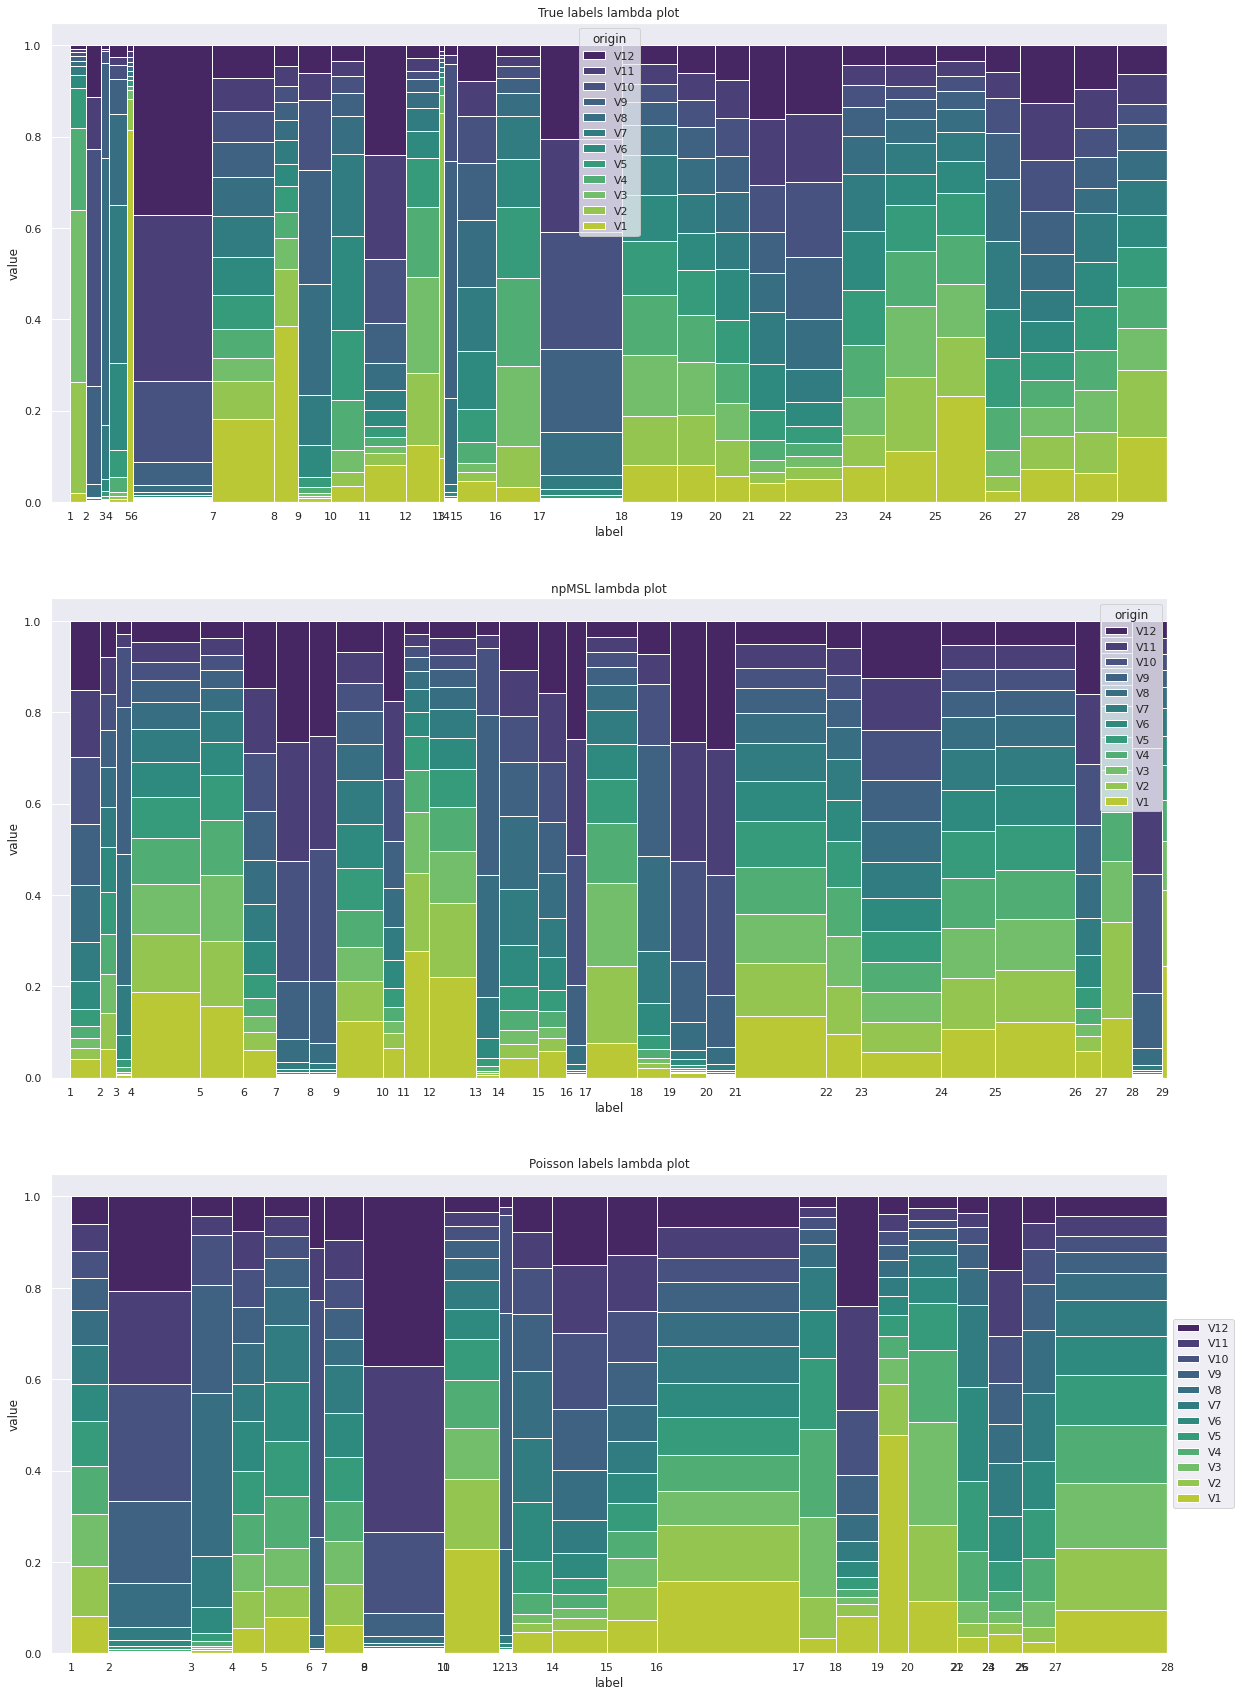

In [34]:
fig, ax = plt.subplots(nrows = 3)
lambda_plotting(data_points[mask], labels=labels[mask], ax = ax[0]);
lambda_plotting(data_points[mask], posteriors = npMSL_posteriors[mask], ax = ax[1]);
lambda_plotting(data_points[mask], labels = poisson_posteriors, ax = ax[2]);
ax[0].set_title("True labels lambda plot")
ax[1].set_title("npMSL lambda plot")
ax[2].set_title("Poisson labels lambda plot")
fig.set_size_inches(20, 30)

# t-SNE visualization

In [40]:
%%time
X = data_points[mask].values
X_embedded = TSNE(n_components=2).fit_transform(X)

CPU times: user 1min 33s, sys: 7.5 ms, total: 1min 33s
Wall time: 1min 33s


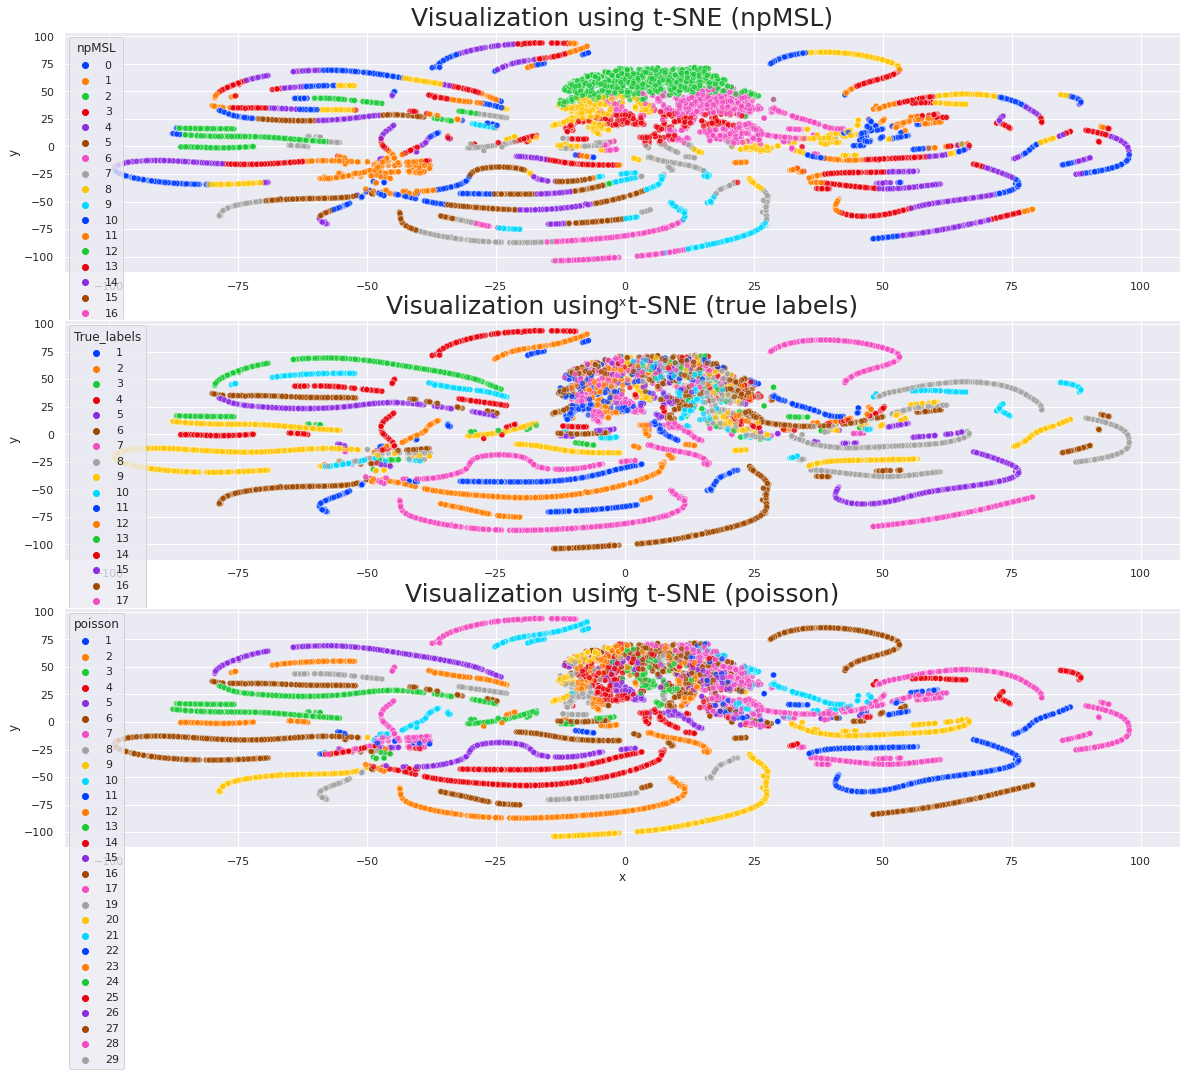

In [43]:
df = pd.DataFrame({
    'x':X_embedded[:,0],
    'y':X_embedded[:,1], 
    'npMSL':np.argmax(npMSL_posteriors[mask].values, axis = 1),
    'True_labels':labels[mask].x.values,
    'poisson': poisson_posteriors.x.values,
})
fig, axs = plt.subplots(nrows=3)
g = sns.scatterplot(data=df ,x='x',y='y' ,hue="npMSL",alpha = 0.7,palette='bright',ax=axs[0]);
g.figure.set_size_inches(20,15);
g.set_title("Visualization using t-SNE (npMSL)",fontsize=25);
g = sns.scatterplot(data=df ,x='x',y='y' ,hue="True_labels",alpha = 0.7,palette='bright',ax=axs[1]);
g.figure.set_size_inches(20,15);
g.set_title("Visualization using t-SNE (true labels)",fontsize=25);
g = sns.scatterplot(data=df ,x='x',y='y' ,hue="poisson",alpha = 0.7,palette='bright',ax=axs[2]);
g.figure.set_size_inches(20,15);
g.set_title("Visualization using t-SNE (poisson)",fontsize=25);

# ARI
Adjusted Rand Index

In [44]:
from sklearn.metrics.cluster import adjusted_rand_score

In [45]:
print("Poisson: ", adjusted_rand_score(df.True_labels, df.poisson))
print("npMSL: ", adjusted_rand_score(df.True_labels, df.npMSL))

Poisson:  0.7454996291902718
npMSL:  0.08813433874347937
